In [2]:
import numpy as np
import pandas as pd
import geopandas as gp
from shapely.geometry import Point

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

### Описание 
Можно ли оценить концентрацию NO2 на поверхности земли, используя данные дистанционного зондирования?

В рамках задания GeoAI Ground-level NO2 Evaluation Challenge необходимо разработать модели машинного обучения для оценки концентраций NO2 на поверхности в различных погодных условиях и временах года, демонстрируя адаптивность и надежность. 

Мы имеем данные наземных измерений со станций мониторинга качества воздуха в континентальной части итальянских регионов Ломбардия и Венето, а также данные дистанционного зондирования NO2 от Sentinel-5P TROPOMI, данные об осадках от CHIRPS и данные о температуре поверхности земли от NOAA, все из Google Earth Engine (GEE).

Необходимо научить модели предсказывать данные наилучшим образом, улучшить метрики, снизить переобучение.
 
https://zindi.africa/competitions/geoai-ground-level-no2-estimation-challenge

Задача регрессии.

Метрика для оценки качества работы модели - RMSE, MAE

### Данные
- ID_Zindi - id наблюдения
- ID - номер станции
- Date - дата
- LAT - широта
- LON - долгота
- Precipitation - осадки
- LST - суточная температура поверхности суши
- AAI - аэрозольный индекс
- CloudFraction - эффективная доля облаков
- NO2_strat - стратосферная концентрация оксида азота
- NO2_total - общая концентрация оксида азота
- NO2_trop - тропосферная концентрация оксида азота
- TropopausePressure - давление в тропопаузе
- GT_NO2 - поверхностная концентрация оксида азота (целевая переменная) 

In [3]:
df = pd.read_csv(r'C:\Users\main6\OneDrive\Документы\jupyter\Pet_pro\data\NO2.csv',
                 parse_dates=['Date'])

In [4]:
df.head()

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,2019-01-01,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.0
1,ID_8JCCXC,2019-01-01,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.0
2,ID_V3136Z,2019-01-01,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.0
3,ID_KRVZDJ,2019-01-01,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.0
4,ID_PR351A,2019-01-01,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.0


In [5]:
df.shape

(86584, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID_Zindi            86584 non-null  object        
 1   Date                86584 non-null  datetime64[ns]
 2   ID                  86584 non-null  object        
 3   LAT                 86584 non-null  float64       
 4   LON                 86584 non-null  float64       
 5   Precipitation       86584 non-null  float64       
 6   LST                 46798 non-null  float64       
 7   AAI                 73709 non-null  float64       
 8   CloudFraction       73709 non-null  float64       
 9   NO2_strat           73709 non-null  float64       
 10  NO2_total           73709 non-null  float64       
 11  NO2_trop            51111 non-null  float64       
 12  TropopausePressure  73709 non-null  float64       
 13  GT_NO2              82051 non-null  float64   

In [7]:
# смотрим на кол-во уникальных значений
df.nunique()

ID_Zindi              86582
Date                   1096
ID                       79
LAT                      79
LON                      79
Precipitation         14264
LST                    2512
AAI                   71468
CloudFraction         63408
NO2_strat               573
NO2_total              1439
NO2_trop               1516
TropopausePressure    70688
GT_NO2                 4245
dtype: int64

In [8]:
# смотрим на основные характеристики
df.describe()

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
count,86584.000000,86584.000000,86584.000000,46798.000000,73709.000000,73709.000000,73709.000000,73709.000000,51111.000000,73709.000000,82051.000000
mean,45.421456,10.014272,2.585528,299.268841,-1.274999,0.200606,0.000045,0.000156,0.000105,16655.112392,24.535051
std,0.225409,1.056637,7.617394,10.927167,0.693003,0.259607,0.000012,0.000103,0.000092,3000.748790,17.108838
min,44.924694,8.736497,0.000000,253.200000,-5.196266,0.000000,0.000013,-0.000012,-0.000025,8614.349685,0.000000
25%,45.249544,9.195325,0.000000,290.920000,-1.749425,0.023900,0.000034,0.000100,0.000047,14432.114060,11.875000
50%,45.478996,9.611738,0.000000,300.760000,-1.349746,0.078478,0.000047,0.000122,0.000071,16711.190570,20.000000
75%,45.601232,10.683357,0.000000,307.940000,-0.878857,0.278451,0.000056,0.000173,0.000129,19252.648570,33.050000
max,45.889734,12.590682,135.396805,327.840000,2.143020,1.000000,0.000073,0.002047,0.001097,24449.007150,188.233333


In [9]:
# не включая ID_Zindi
df.iloc[:,1:].describe(include=[object])

,ID
count,86584
unique,79
top,PD01
freq,1096


Проанализируем целевую переменную

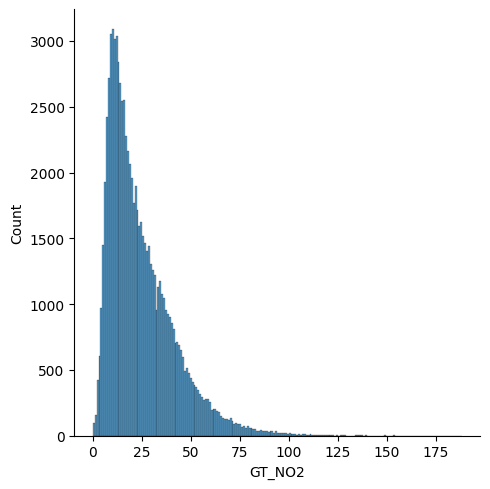

In [10]:
sns.displot(df['GT_NO2']);

In [11]:
if stats.shapiro(df['GT_NO2']).pvalue >= 0.05:
    print('Распределение нормальное')
else:
    print('Распределение не нормальное')

Распределение не нормальное


# Feature engineering

In [12]:
# разобьем столбец с датой на два: месяц и год
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

In [13]:
# создадим новый признак, который будет указывать на соотношение
# тропосфреной и стратосферной концентраций
df['NO2_ratio'] = df['NO2_trop'] / df['NO2_strat']

In [14]:
# создадим признак суммарной концентрации
df["Sum_Concentration"] = df["NO2_strat"] + df["NO2_total"] + df["NO2_trop"]

In [15]:
# переведем градусы Кельвина в градусы Цельсия
df['LST'] = df['LST'] - 273.15
df[15:18]

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,month,year,NO2_ratio,Sum_Concentration
15,ID_UNRKV2,2019-01-01,X10019,45.690429,9.484261,0.000000,8.33,-0.531419,0.140807,0.000023,0.000245,0.000288,14429.31480,15.925,1,2019,12.413793,0.000556
16,ID_OX46E7,2019-01-01,X10038,45.619244,8.756970,0.000000,9.83,-0.580316,0.121120,0.000023,0.000156,0.000133,14425.69705,27.775,1,2019,5.807860,0.000312
17,ID_XFGGN9,2019-01-01,X10079,45.412772,10.683357,1.800207,NaN,-0.352985,0.622817,0.000024,0.000171,NaN,14442.65422,22.250,1,2019,NaN,NaN


In [16]:
# для удобства переименуем столбец с целевой переменной
df['target'] = df['GT_NO2']

# удалим id и старый столбцы
df = df.drop(['ID_Zindi', 'GT_NO2'], axis=1)

In [17]:
df[:5]

,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,month,year,NO2_ratio,Sum_Concentration,target
0,2019-01-01,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,1,2019,NaN,NaN,31.0
1,2019-01-01,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,1,2019,NaN,NaN,42.0
2,2019-01-01,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,1,2019,NaN,NaN,31.0
3,2019-01-01,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,1,2019,NaN,NaN,30.0
4,2019-01-01,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,1,2019,NaN,NaN,58.0


Посмотрим на корреляцию признаков и целевой переменной

In [18]:
features = df.select_dtypes(include=['number']).columns.tolist()
features

['LAT',
 'LON',
 'Precipitation',
 'LST',
 'AAI',
 'CloudFraction',
 'NO2_strat',
 'NO2_total',
 'NO2_trop',
 'TropopausePressure',
 'month',
 'year',
 'NO2_ratio',
 'Sum_Concentration',
 'target']

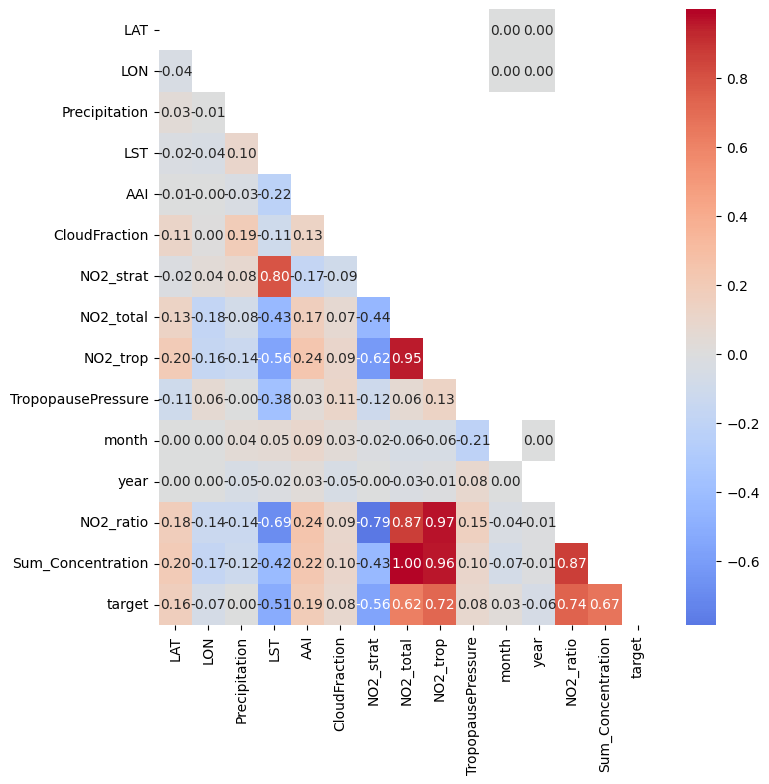

In [19]:
matrix = np.triu(df[features].corr(method='spearman'))

plt.figure(figsize=(8, 8))

sns.heatmap(df[features].corr(method='spearman'), annot=True,
            fmt='.2f', center=0, cmap='coolwarm', mask=matrix)
plt.show()

- Целевая переменная сильно коррелирует с общей, тропосферной и относительной концентрациями оксида
- Так же можно заметить, что две концентрации коррелируют между собой и с другими признаками (NO2_trop и NO2_total)

In [20]:
# удалим сильно коррелирующие признаки
df_clean = df.drop(['NO2_trop', 'NO2_total'], axis=1)
df_clean[:5]

,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,TropopausePressure,month,year,NO2_ratio,Sum_Concentration,target
0,2019-01-01,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,14440.82126,1,2019,NaN,NaN,31.0
1,2019-01-01,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,14441.79815,1,2019,NaN,NaN,42.0
2,2019-01-01,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,14437.38294,1,2019,NaN,NaN,31.0
3,2019-01-01,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,14440.83831,1,2019,NaN,NaN,30.0
4,2019-01-01,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,14438.79037,1,2019,NaN,NaN,58.0


Посмотрим на распределение признаков

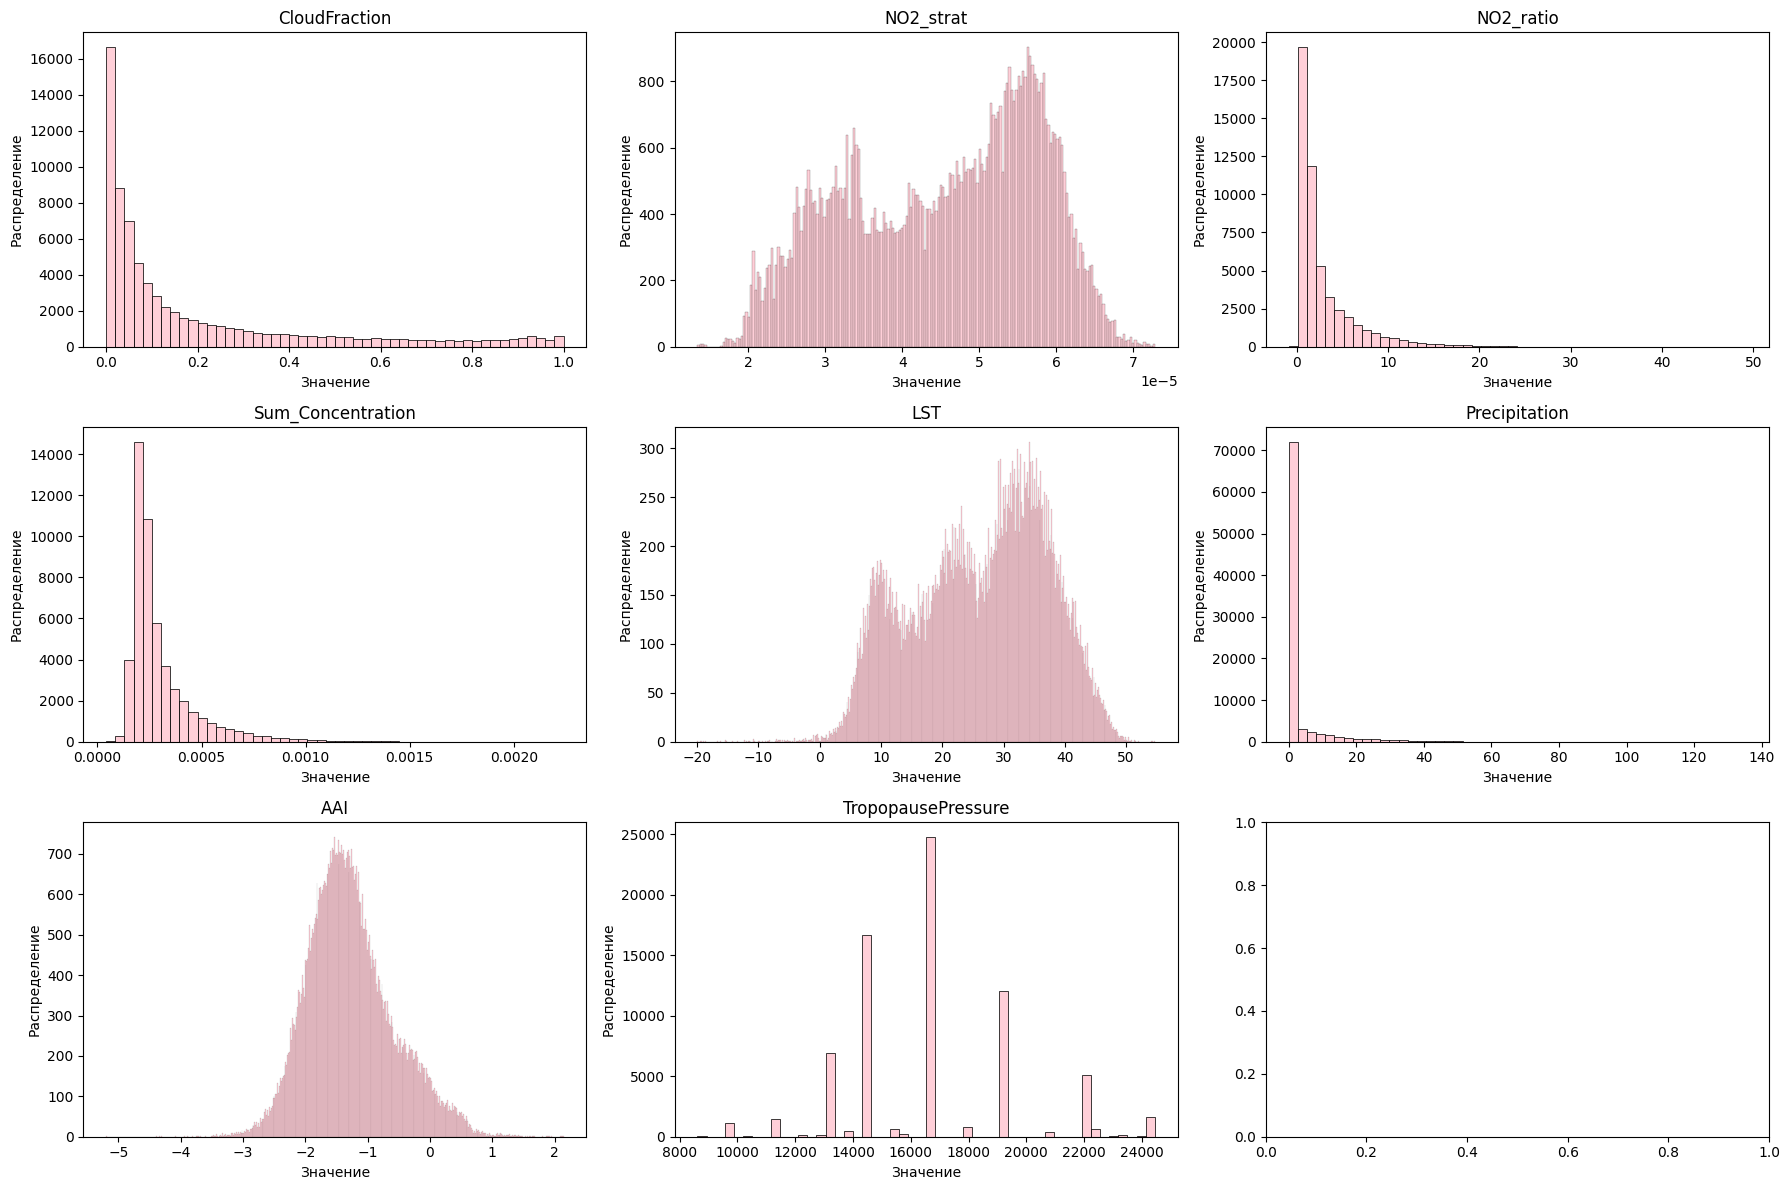

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

sns.histplot(df_clean['CloudFraction'], bins=50, kde=False, color='pink', 
             edgecolor='black', ax=axes[0, 0])
axes[0, 0].set_xlabel('Значение')
axes[0, 0].set_ylabel('Распределение')
axes[0, 0].set_title('CloudFraction')

sns.histplot(df_clean['NO2_strat'], bins=200, kde=False, color='pink', 
             edgecolor='black', ax=axes[0, 1])
axes[0, 1].set_xlabel('Значение')
axes[0, 1].set_ylabel('Распределение')
axes[0, 1].set_title('NO2_strat')

sns.histplot(df_clean['NO2_ratio'], bins=50, kde=False, color='pink', 
             edgecolor='black', ax=axes[0, 2])
axes[0, 2].set_xlabel('Значение')
axes[0, 2].set_ylabel('Распределение')
axes[0, 2].set_title('NO2_ratio')

sns.histplot(df_clean['Sum_Concentration'], bins=50, kde=False, color='pink', 
             edgecolor='black', ax=axes[1, 0])
axes[1, 0].set_xlabel('Значение')
axes[1, 0].set_ylabel('Распределение')
axes[1, 0].set_title('Sum_Concentration')

sns.histplot(df_clean['LST'], bins=500, kde=False, color='pink', 
             edgecolor='black', ax=axes[1, 1])
axes[1, 1].set_xlabel('Значение')
axes[1, 1].set_ylabel('Распределение')
axes[1, 1].set_title('LST')

sns.histplot(df_clean['Precipitation'], bins=50, kde=False, color='pink', 
             edgecolor='black', ax=axes[1, 2])
axes[1, 2].set_xlabel('Значение')
axes[1, 2].set_ylabel('Распределение')
axes[1, 2].set_title('Precipitation')

sns.histplot(df_clean['AAI'], bins=500, kde=False, color='pink', 
             edgecolor='black', ax=axes[2, 0])
axes[2, 0].set_xlabel('Значение')
axes[2, 0].set_ylabel('Распределение')
axes[2, 0].set_title('AAI')

sns.histplot(df_clean['TropopausePressure'], bins=50, kde=False, color='pink', 
             edgecolor='black', ax=axes[2, 1])
axes[2, 1].set_xlabel('Значение')
axes[2, 1].set_ylabel('Распределение')
axes[2, 1].set_title('TropopausePressure')

plt.tight_layout()

plt.show()

- признаки с большим числом выбросов можно будет заполнить медианными значениями
- остальные числовые признаки средними

# EDA

Визуализируем местоположение станций мониторинга качества воздуха на карте

,COD_RIP,COD_REG,DEN_REG,Shape_Leng,Shape_Area,geometry
0,1,1,Piemonte,1.333428e+06,2.538670e+10,"POLYGON ((8.43834 46.46410, 8.43841 46.46378, ..."
1,1,2,Valle d'Aosta/VallÃ©e d'Aoste,3.258364e+05,3.260854e+09,"POLYGON ((7.57144 45.98758, 7.57241 45.98744, ..."
2,1,3,Lombardia,1.511132e+06,2.386310e+10,"MULTIPOLYGON (((10.24930 46.61838, 10.25179 46..."
3,2,4,Trentino-Alto Adige/SÃ¼dtirol,8.598731e+05,1.360472e+10,"POLYGON ((12.20668 47.08627, 12.20703 47.08624..."
4,2,5,Veneto,1.141798e+06,1.840685e+10,"POLYGON ((12.50603 46.67803, 12.50614 46.67754..."


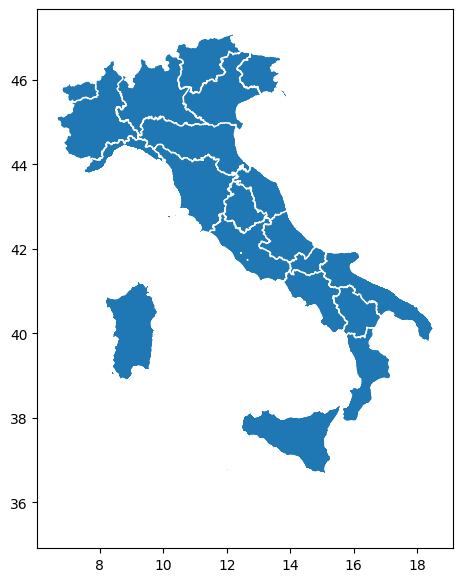

In [22]:
# загружаем файл с GeoDataFrame регионов Италии
df_prov = gp.read_file(
    r'C:\Users\main6\OneDrive\Документы\jupyter\Pet_pro\data\Reg01012016\Reg01012016_WGS84.shp').to_crs({'init':
                                                                                                         'epsg:4326'})

ax = df_prov.plot(edgecolor='white', linewidth=1, figsize=(15, 7));

df_prov[:5]

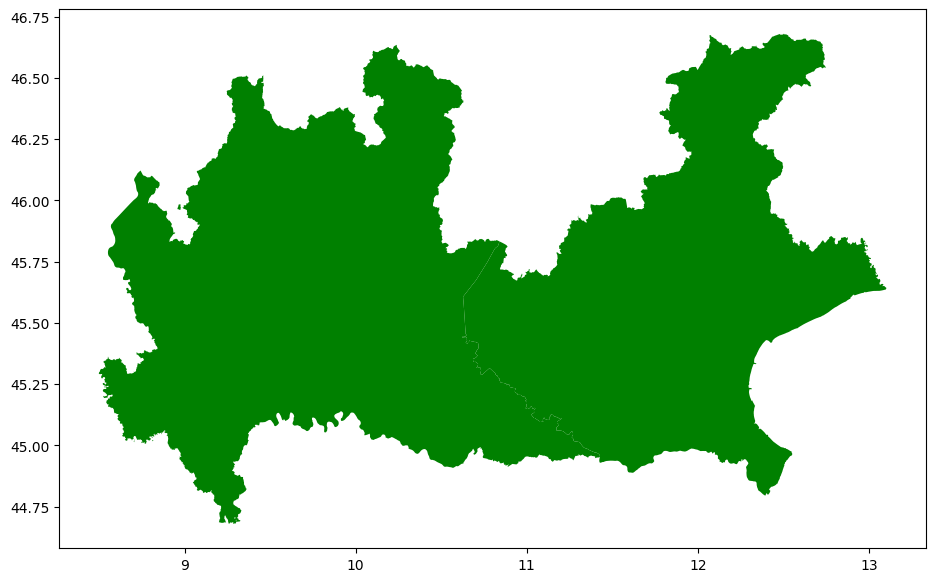

In [28]:
# выбираем исследуемые провинции
df_prov[df_prov['DEN_REG'].isin(['Lombardia', 'Veneto']) == True].plot(figsize=(15, 7), color='green');

In [23]:
df_geo = df_clean.copy()

# создадим новый столбец со списками из долготы и широты
df_geo['coordinates'] = df_geo[['LON', 'LAT']].values.tolist()

# преобразуем в геоформат Point
df_geo['coordinates'] = df_geo['coordinates'].apply(Point)
df_geo.head()

,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,TropopausePressure,month,year,NO2_ratio,Sum_Concentration,target,coordinates
0,2019-01-01,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,14440.82126,1,2019,NaN,NaN,31.0,POINT (11.90355081 45.60158469)
1,2019-01-01,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,14441.79815,1,2019,NaN,NaN,42.0,POINT (11.84082978 45.37100479)
2,2019-01-01,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,14437.38294,1,2019,NaN,NaN,31.0,POINT (12.06086934 45.04582512)
3,2019-01-01,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,14440.83831,1,2019,NaN,NaN,30.0,POINT (11.55324086 45.10407489)
4,2019-01-01,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,14438.79037,1,2019,NaN,NaN,58.0,POINT (11.79015164 45.03875842)


In [24]:
# преобразуем в GeoDataFrame
df_geo = gp.GeoDataFrame(df_geo, geometry='coordinates')

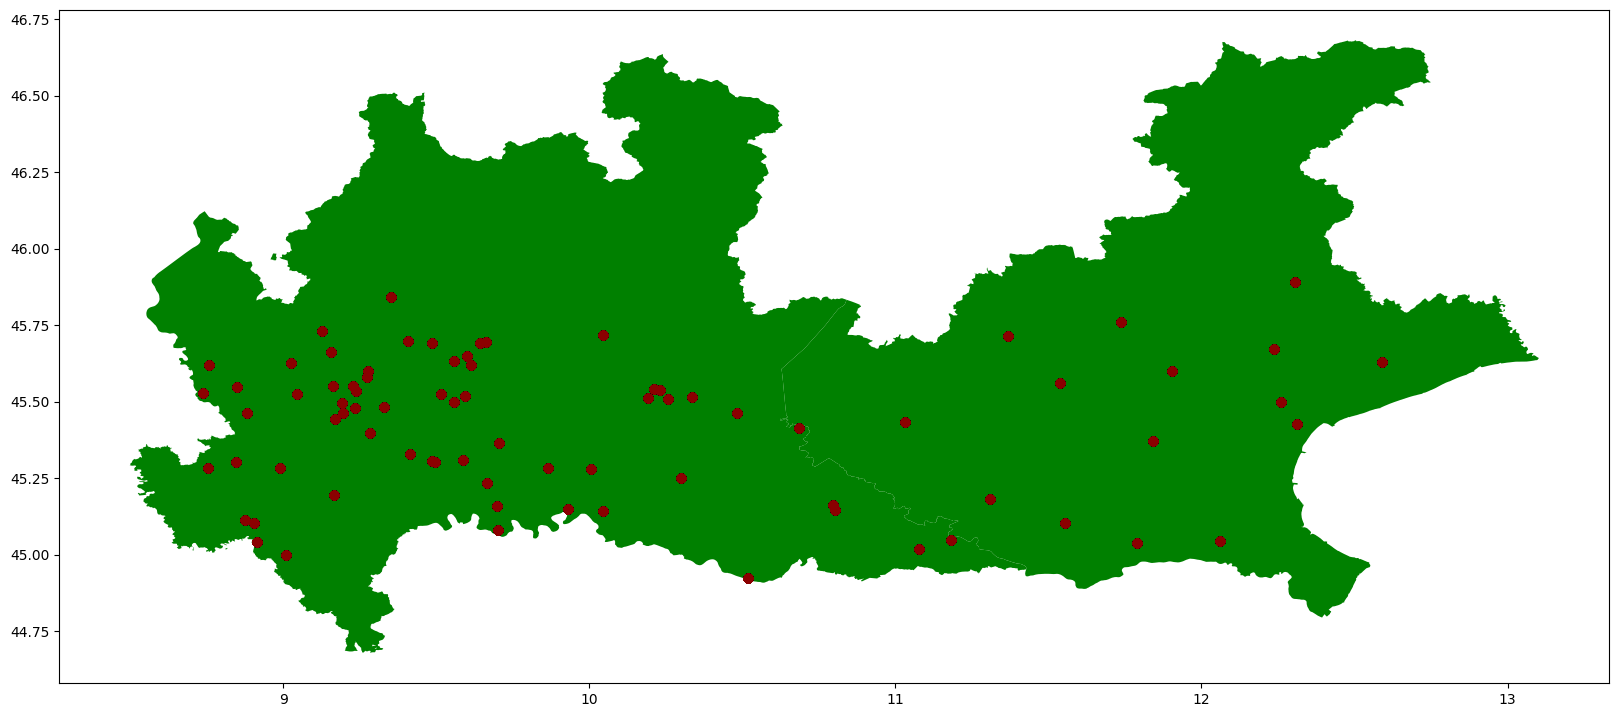

In [27]:
# наносим координаты на карту
fig, ax = plt.subplots(1, figsize=(20, 10))
base = df_prov[df_prov['DEN_REG'].isin(['Lombardia', 'Veneto']) == True].plot(ax=ax, color='green')
df_geo.plot(ax=base, color='darkred');

Посмотрим на динамику изменения целевой переменной в течении всего исследуемого периода

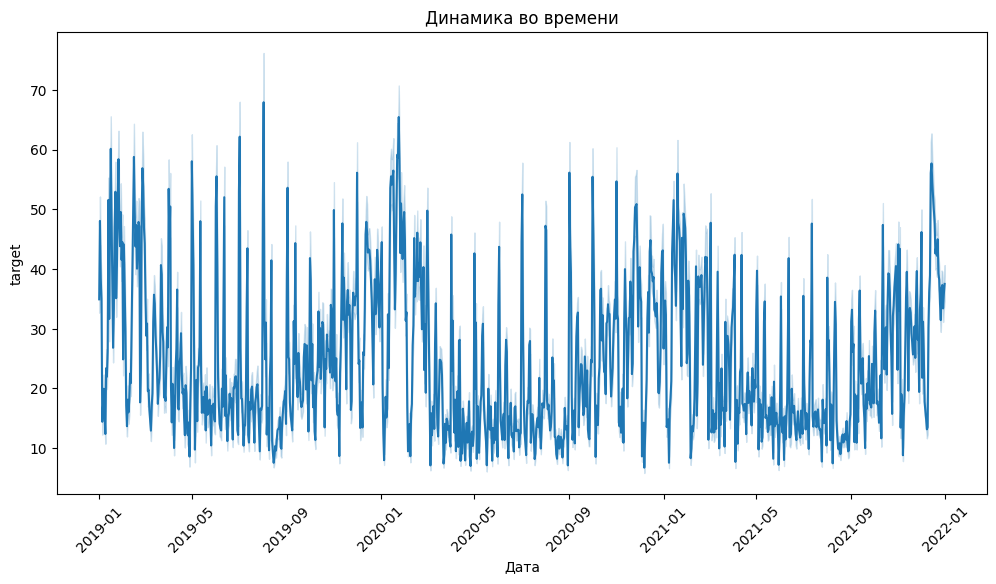

In [32]:
plt.figure(figsize=(12, 6))

sns.lineplot(x ='Date', y='target', data=df_clean)

plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('target')
plt.title('Динамика во времени')

plt.show()

In [33]:
df_clean.drop('Date', axis=1, inplace=True)

#  Гипотезы

1. Температура влияет на концентрацию NO2 - чем она выше тем, тем меньше оксида на поверхности;
2. Чем чище воздух, тем меньше концентрация исследуемого вещества;
3. Целевая переменная не зависит от эффективной доли облаков;
4. Давление в тропопаузе не оказывает большого влияния на концентрацию оксида азота;
5. Чем больше значение суммарной концентрации азота, тем выше значение целевой переменной;
6. Чем выше концентрация NO2 в стратосфере, тем она ниже на поверхности;
7. Чем выше уровень осадков, тем выше суммарная концентрация окида азота, а следовательно и поверхностная;
8. При более высокой температуре концентрация оксида азота ниже, следовательно в зимние месяцы концентрация должна быть выше.

In [34]:
def get_bins(col: str, name: str):
    """
    Функция разделения признака по квартилям
    для разведочного анализа распределения
    """
    bin_min = df_clean[col].describe().loc['min']
    bin_25 = df_clean[col].describe().loc['25%']
    bin_50 = df_clean[col].describe().loc['50%']
    bin_75 = df_clean[col].describe().loc['75%']
    bin_max = df_clean[col].describe().loc['max']
    
    df_clean[name] = pd.cut(df_clean[col],
                      bins= [bin_min, bin_25, bin_50, bin_75, bin_max],
                      labels=['low', 'middle', 'middle+', 'high'])

# 1 гипотеза

- Температура влияет на концентрацию NO2
- Чем она выше тем, тем меньше оксида на поверхности

In [35]:
get_bins(col='LST', name='LST_bins')

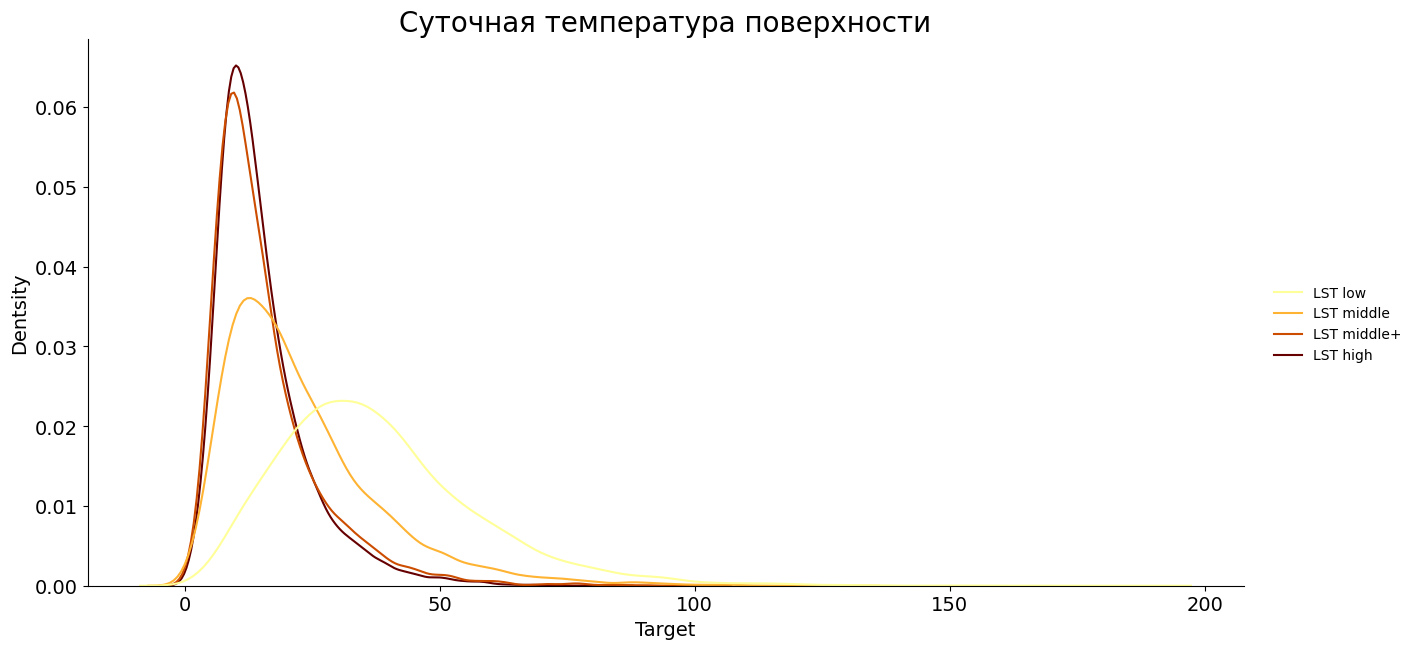

In [36]:
sns.displot(
    {
        'LST low': df_clean[df_clean.LST_bins == 'low'].target,
        'LST middle': df_clean[df_clean.LST_bins == 'middle'].target,
        'LST middle+': df_clean[df_clean.LST_bins == 'middle+'].target,
        'LST high': df_clean[df_clean.LST_bins == 'high'].target
    },
    kind='kde',
    common_norm=False,
    palette='afmhot_r',
    height=6,
    aspect=2.1)

plt.title('Cуточная температура поверхности', fontsize=20)
plt.xlabel('Target', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

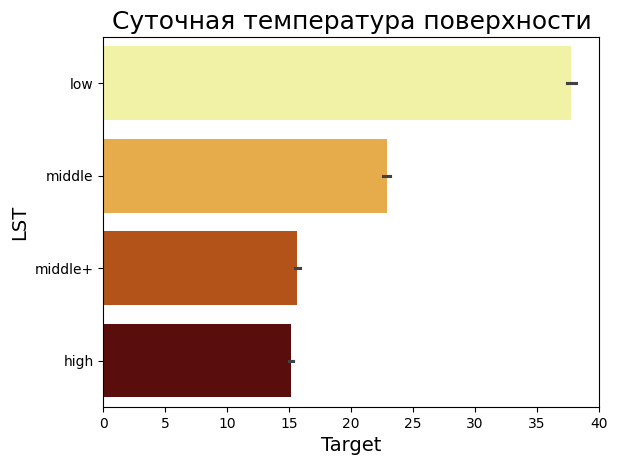

In [37]:
sns.barplot(x='target', y='LST_bins', data=df_clean, palette='afmhot_r')

plt.title('Cуточная температура поверхности', fontsize=18)
plt.xlabel('Target', fontsize=14)
plt.ylabel('LST', fontsize=14)

plt.show()

- чем выше температура на поверхности, тем меньше концентрация оксида азота
- гипотеза подтвердилась

# 2 гипотеза

- Чем чище воздух (ниже индекс), тем меньше концентрация исследуемого вещества

In [38]:
get_bins(col='AAI', name='AAI_bins')

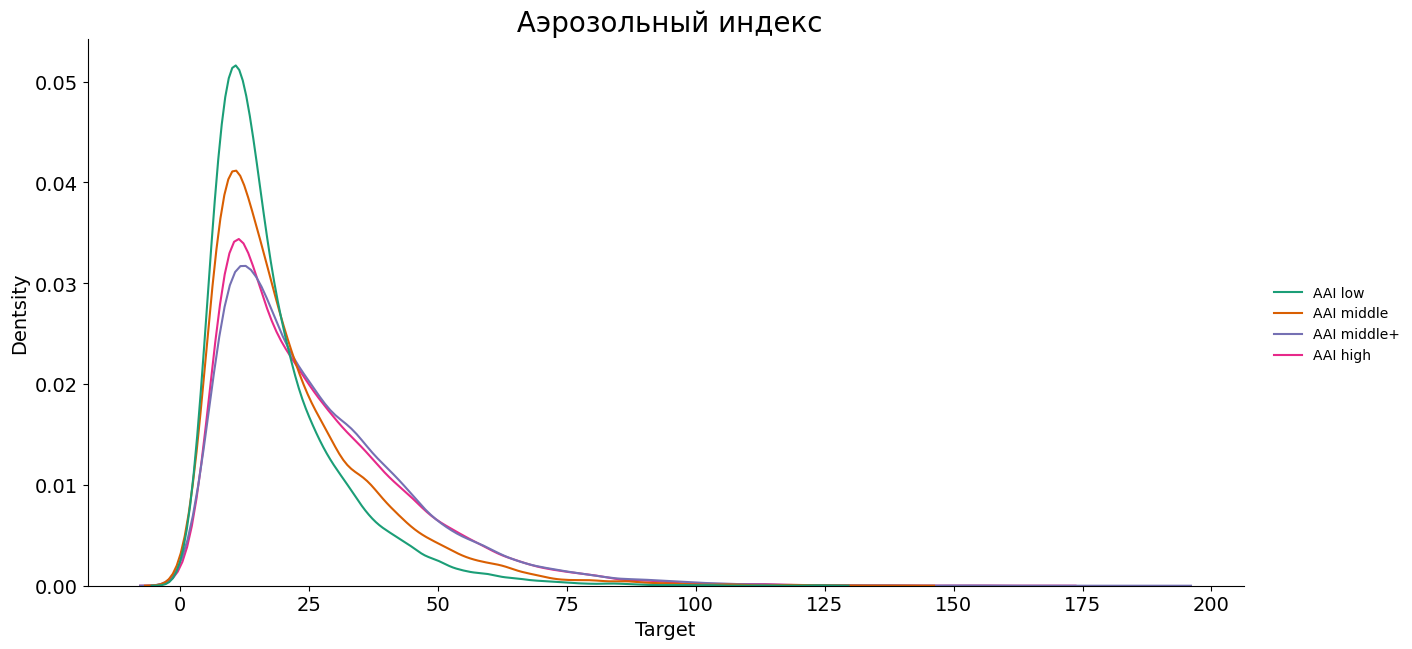

In [39]:
sns.displot(
    {
        'AAI low': df_clean[df_clean.AAI_bins == 'low'].target,
        'AAI middle': df_clean[df_clean.AAI_bins == 'middle'].target,
        'AAI middle+': df_clean[df_clean.AAI_bins == 'middle+'].target,
        'AAI high': df_clean[df_clean.AAI_bins == 'high'].target
    },
    kind='kde',
    common_norm=False,
    palette='Dark2',
    height=6,
    aspect=2.1)

plt.title(' Аэрозольный индекс', fontsize=20)
plt.xlabel('Target', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

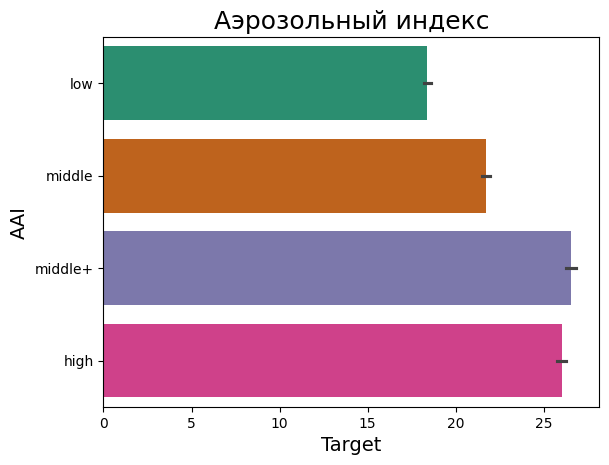

In [40]:
sns.barplot(x='target', y='AAI_bins', data=df_clean, palette='Dark2')

plt.title('Аэрозольный индекс', fontsize=18)
plt.xlabel('Target', fontsize=14)
plt.ylabel('AAI', fontsize=14)

plt.show()

- при самом низком аэрозольном индексе содержание NO2 действительно наименьшее
- но далее распределение неоднозначно
- гипотеза подтвердилась отчасти

# 3 гипотеза

- Целевая переменная не зависит от эффективной доли облаков

In [41]:
get_bins(col='CloudFraction', name='CloudFraction_bins')

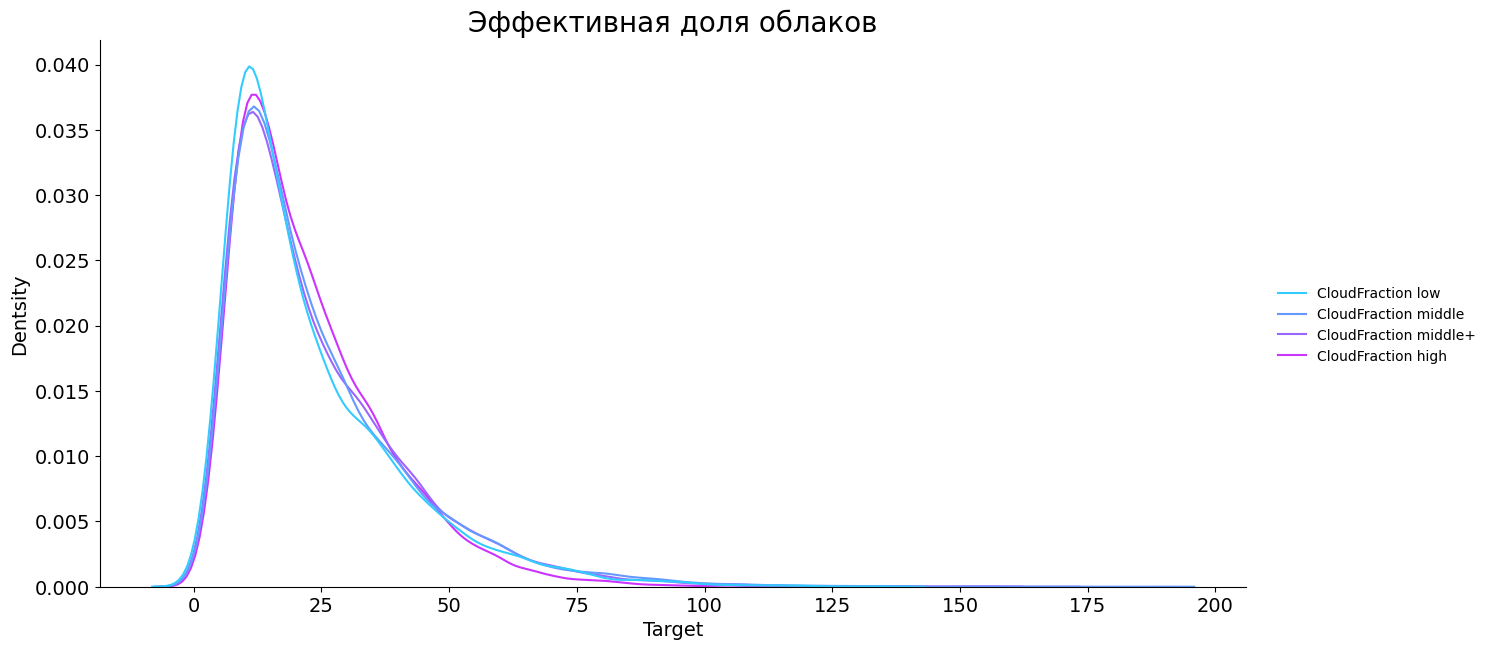

In [42]:
sns.displot(
    {
        'CloudFraction low': df_clean[df_clean.CloudFraction_bins == 'low'].target,
        'CloudFraction middle': df_clean[df_clean.CloudFraction_bins == 'middle'].target,
        'CloudFraction middle+': df_clean[df_clean.CloudFraction_bins == 'middle+'].target,
        'CloudFraction high': df_clean[df_clean.CloudFraction_bins == 'high'].target
    },
    kind='kde',
    common_norm=False,
    palette='cool',
    height=6,
    aspect=2.1)

plt.title('Эффективная доля облаков', fontsize=20)
plt.xlabel('Target', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

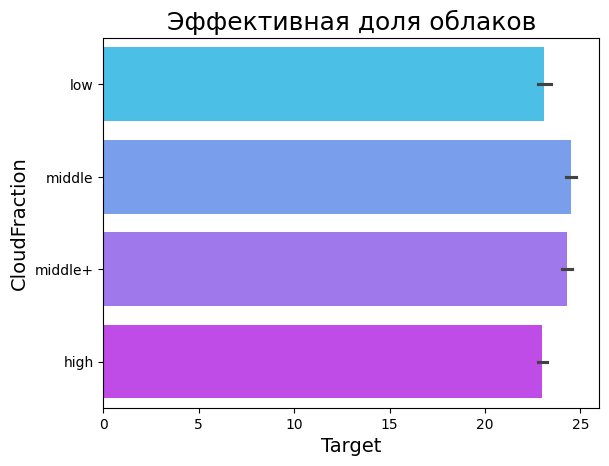

In [43]:
sns.barplot(x='target', y='CloudFraction_bins', data=df_clean, palette='cool')

plt.title('Эффективная доля облаков', fontsize=18)
plt.xlabel('Target', fontsize=14)
plt.ylabel('CloudFraction', fontsize=14)

plt.show()

- сначала можно увидеть, что чем меньше облачность, тем ниже концентрация оксида азота
- но далее последовательность нарушается
- гипотеза подтвердилась - зависимости нет

# 4 гипотеза

- Давление в тропопаузе (граница между тропосферой и стратосферой) не оказывает большого влияния на концентрацию оксида азота

In [44]:
get_bins(col='TropopausePressure', name='TP_bins')

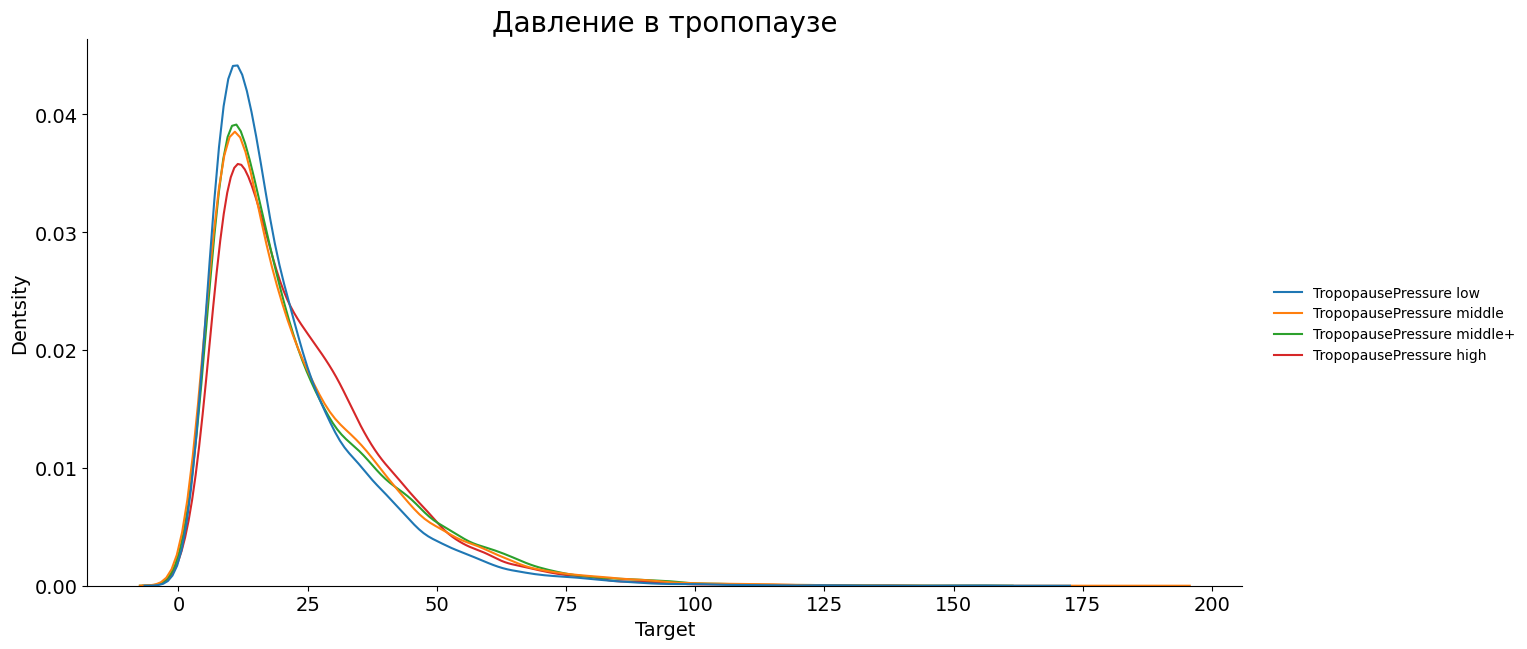

In [45]:
sns.displot(
    {
        'TropopausePressure low': df_clean[df_clean.TP_bins == 'low'].target,
        'TropopausePressure middle': df_clean[df_clean.TP_bins == 'middle'].target,
        'TropopausePressure middle+': df_clean[df_clean.TP_bins == 'middle+'].target,
        'TropopausePressure high': df_clean[df_clean.TP_bins == 'high'].target
    },
    kind='kde',
    common_norm=False,
    height=6,
    aspect=2.1)

plt.title('Давление в тропопаузе', fontsize=20)
plt.xlabel('Target', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

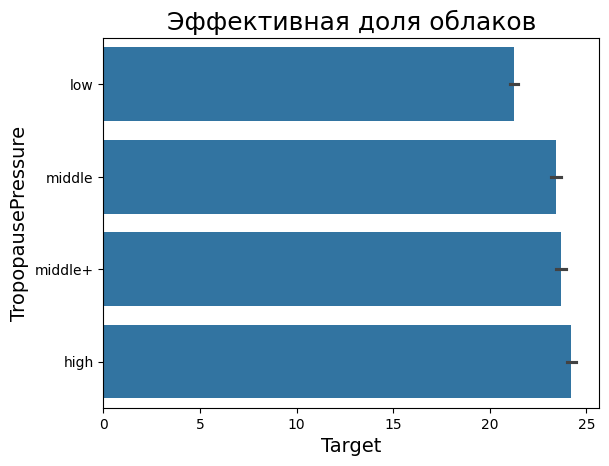

In [46]:
sns.barplot(x='target', y='TP_bins', data=df_clean)

plt.title('Эффективная доля облаков', fontsize=18)
plt.xlabel('Target', fontsize=14)
plt.ylabel('TropopausePressure', fontsize=14)

plt.show()

- средние значения признака распределы по разному - некоторые выше самых больших значений давления, а некоторые ниже
- данная гипотеза подтверждена

# 5 гипотеза

- Чем больше значение суммарной концентрации азота, тем выше значение целевой переменной

In [47]:
get_bins(col='Sum_Concentration', name='NO2_sum_bins')

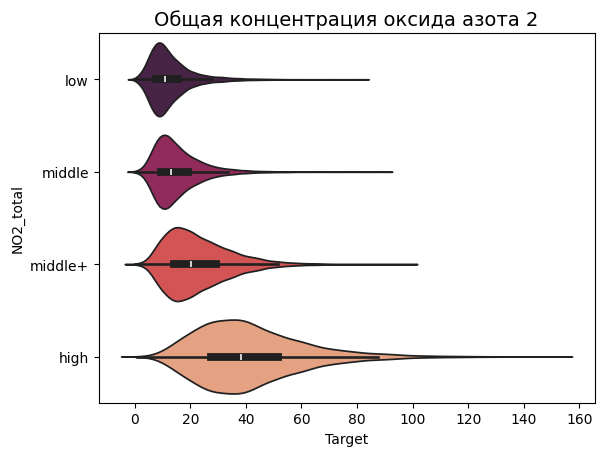

In [48]:
sns.violinplot(x='target', y='NO2_sum_bins', data=df_clean, palette='rocket')

plt.title('Общая концентрация оксида азота 2', fontsize=14)
plt.xlabel('Target')
plt.ylabel('NO2_total')
plt.show()

- гипотеза верна
- с увеличением суммарной концентрации увеличивается и концентрация NO2 на поверхности

# 6 гипотеза

- Чем выше концентрация NO2 в стратосфере, тем она ниже на поверхности

In [49]:
get_bins(col='NO2_strat', name='NO2_strat_bins')

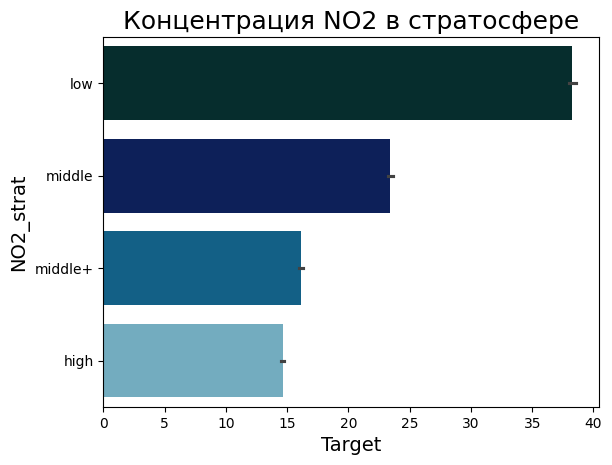

In [50]:
sns.barplot(x='target', y='NO2_strat_bins', data=df_clean, palette='ocean')

plt.title('Концентрация NO2 в стратосфере', fontsize=18)
plt.xlabel('Target', fontsize=14)
plt.ylabel('NO2_strat', fontsize=14)

plt.show()

- поверхностная концентрация оксида азота обратнопропорциональна стратосферной
- гипотеза оказалась верной

# 7 гипотеза 

- Чем выше уровень осадков, тем выше суммарная концентрация окида азота, а следовательно и поверхностная

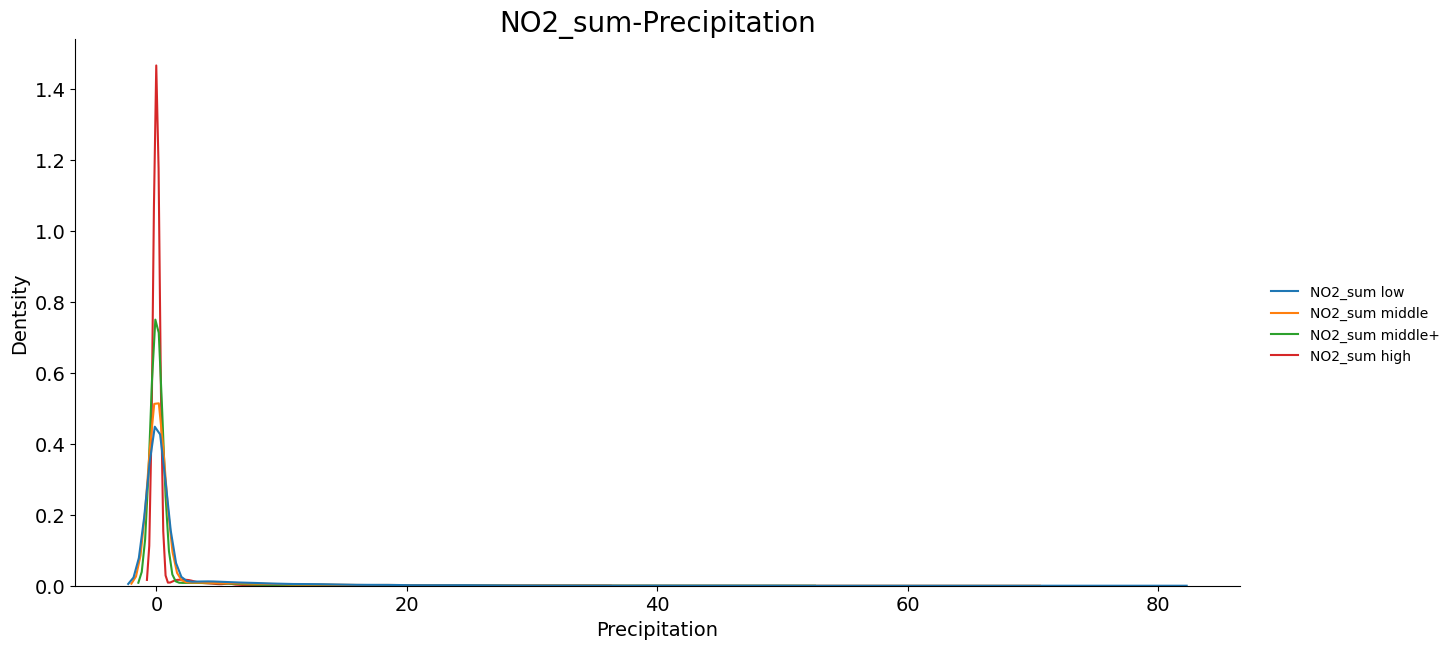

In [51]:
sns.displot(
    {
        'NO2_sum low': df_clean[df_clean.NO2_sum_bins == 'low'].Precipitation,
        'NO2_sum middle': df_clean[df_clean.NO2_sum_bins == 'middle'].Precipitation,
        'NO2_sum middle+': df_clean[df_clean.NO2_sum_bins == 'middle+'].Precipitation,
        'NO2_sum high': df_clean[df_clean.NO2_sum_bins == 'high'].Precipitation
    },
    kind='kde',
    common_norm=False,
    height=6,
    aspect=2.1)

plt.title('NO2_sum-Precipitation', fontsize=20)
plt.xlabel('Precipitation', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

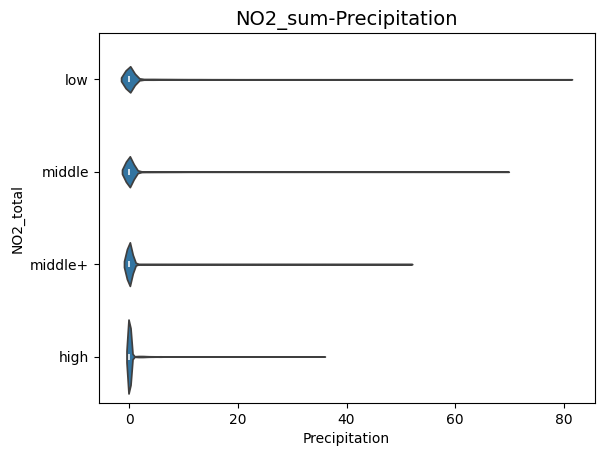

In [52]:
sns.violinplot(x='Precipitation', y='NO2_sum_bins', data=df_clean)

plt.title('NO2_sum-Precipitation', fontsize=14)
plt.xlabel('Precipitation')
plt.ylabel('NO2_total')
plt.show()

- нет никакой пропорциональности между признаками
- гипотеза неверна

# 8 гипотеза

- При более высокой температуре концентрация оксида азота ниже, следовательно в зимние месяцы концентрация должна быть выше

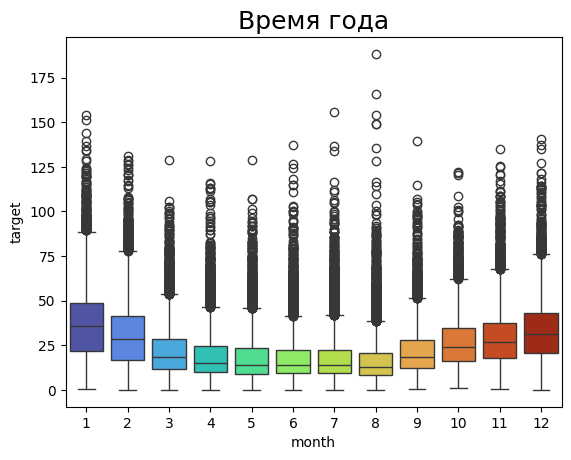

In [53]:
sns.boxplot(x='month', y='target', data=df_clean, palette='turbo')

plt.title('Время года', fontsize=18)
plt.show()

- зимой значения целевой переменной выше, а летом ниже
- гипотеза подтверждается

# Итоги

1. Чем выше температура на поверхности, тем меньше концентрация оксида азота (верно);
2. При самом низком аэрозольном индексе содержание NO2 действительно наименьшее, но далее распределение неоднозначно (верно отчасти);
3. Сначала можно увидеть, что чем меньше облачность, тем ниже концентрация оксида азота, но далее последовательность нарушается (верно);
4. Средние значения признака распределы по разному - некоторые выше самых больших значений давления, а некоторые ниже (верно);
5. С увеличением суммарной концентрации увеличивается и концентрация NO2 на поверхности (верно);
6. Поверхностная концентрация оксида азота обратнопропорциональна стратосферной (верно);
7. Нет никакой пропорциональности между признаками (неверно);
8. Зимой значения целевой переменной выше, а летом ниже (верно).

In [54]:
# удалим временно созданные признаки
df_clean = df_clean.drop(['LST_bins', 'AAI_bins', 'CloudFraction_bins',
              'TP_bins', 'NO2_sum_bins', 'NO2_strat_bins'], axis=1)

In [63]:
df_clean.to_csv(r'C:\Users\main6\OneDrive\Документы\jupyter\Pet_pro\data\df_clean.csv',
                index=False)